In [89]:
from pathlib import Path
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from knee_stress_predict.config import raw_data_dir, processed_data_dir
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

## Load data

In [90]:
data_set_name = "set_3"
train_file_path = Path.joinpath(processed_data_dir, data_set_name,  "train_cleaned.csv")
test_file_path = Path.joinpath(processed_data_dir, data_set_name,  "test_cleaned.csv")
train_data = pd.read_csv(train_file_path).drop('Unnamed: 0', axis=1)
test_data = pd.read_csv(test_file_path).drop('Unnamed: 0', axis=1)

In [91]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27002 entries, 0 to 27001
Data columns (total 53 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Code                           27002 non-null  object 
 1   Patella_PN                     27002 non-null  int64  
 2   Femur_PN                       27002 non-null  int64  
 3   Tibia_PN                       27002 non-null  int64  
 4   Patella_Car_PN                 27002 non-null  int64  
 5   Femur_Car_PN                   27002 non-null  int64  
 6   Tibia_M_Car_PN                 27002 non-null  int64  
 7   Tibia_L_Car_PN                 27002 non-null  int64  
 8   Patella_volume                 27002 non-null  float64
 9   Femur_volume                   27002 non-null  float64
 10  Tibia_volume                   27002 non-null  float64
 11  Patella_Car_volume             27002 non-null  float64
 12  Femur_Car_volume               27002 non-null 

In [92]:
def get_tframe_dataset(tframe_num, dataset):
    tframe_dataset = dataset[dataset['frame'] == tframe_num]
    return tframe_dataset

In [93]:
train_datasets = get_tframe_dataset(0, train_data)
test_datasets = get_tframe_dataset(0, test_data)

## Drop unnecessary columns

We need to delete "Max_tib_med_contact_pressure" and "Max_tib_lat_contact_pressure" since these features are for 0-time points only. In this notebook, we are more concentrated on maximal contact pressure, which are: "med_Max_all_frames" and "lat_Max_all_frames"

In [94]:
train_datasets = train_datasets.drop(["frame", "Code", "Max_tib_med_contact_pressure", "Max_tib_lat_contact_pressure"], axis=1)

test_datasets = test_datasets.drop(["frame", "Code", "Max_tib_med_contact_pressure", "Max_tib_lat_contact_pressure"], axis=1)

In [95]:
train_datasets

,Patella_PN,Femur_PN,Tibia_PN,Patella_Car_PN,Femur_Car_PN,Tibia_M_Car_PN,Tibia_L_Car_PN,Patella_volume,Femur_volume,Tibia_volume,...,tib_lat_ishealthy,femur_gap_dist,Max_dist_femur_tibia_lat_car,Min_dist_femur_tibia_lat_car,Mean_dist_femur_tibia_lat_car,Max_dist_femur_tibia_med_car,Min_dist_femur_tibia_med_car,Mean_dist_femur_tibia_med_car,lat_Max_all_frames,med_Max_all_frames
0,1126,4113,2684,5900,21030,2840,2840,33039.218053,228671.171460,134963.134980,...,1,22.935425,13.560157,0.800195,6.226970,10.677269,1.029139,4.306716,20.057634,31.649405
241,771,3414,2596,4485,18385,2840,2840,21736.919532,184294.924991,127637.611277,...,1,19.539911,12.892850,1.504442,4.844820,9.243396,1.418712,4.015682,18.555532,26.223894
482,730,3404,2600,5055,18755,2840,2840,20866.993760,184114.045604,128295.783408,...,1,18.387004,11.617199,1.119438,4.698536,9.107268,1.398252,3.890993,19.447876,24.808067
723,667,3814,2631,5245,19370,2840,2840,17949.168458,221202.458278,137472.394625,...,1,19.128202,12.324972,2.210197,6.003760,10.941657,2.428147,5.948101,19.930437,25.919180
964,997,3569,3013,5035,22675,2840,2840,31601.733987,206925.519779,168725.205892,...,1,19.937188,16.729068,1.207820,6.030796,10.350523,0.664740,4.025312,24.263035,16.543530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25797,633,3084,2205,4255,20260,2185,2840,15168.028148,146698.667898,102326.881891,...,1,21.102991,14.732158,1.686715,5.659945,13.039994,1.308433,4.848711,20.220541,36.707184
26038,795,3669,2724,4765,20410,2840,2840,22375.020348,207318.185631,146786.471170,...,1,22.148186,16.633343,1.874496,6.641354,15.426130,2.258161,4.898385,19.478767,22.278835
26279,801,3805,2575,4885,20400,2840,2840,22439.863013,215968.865103,136753.285023,...,1,22.762806,17.640301,1.481010,6.875417,12.561378,2.246910,4.471387,20.616781,26.929873
26520,868,3794,3029,5430,20755,2840,2840,25084.417057,216622.182978,168327.403757,...,1,19.888791,19.743281,2.204936,6.574413,16.267729,1.759706,5.525146,17.599583,22.764488


In [96]:
test_datasets

,Patella_PN,Femur_PN,Tibia_PN,Patella_Car_PN,Femur_Car_PN,Tibia_M_Car_PN,Tibia_L_Car_PN,Patella_volume,Femur_volume,Tibia_volume,...,tib_lat_ishealthy,femur_gap_dist,Max_dist_femur_tibia_lat_car,Min_dist_femur_tibia_lat_car,Mean_dist_femur_tibia_lat_car,Max_dist_femur_tibia_med_car,Min_dist_femur_tibia_med_car,Mean_dist_femur_tibia_med_car,lat_Max_all_frames,med_Max_all_frames
0,788,4137,2689,5575,21035,2840,2840,22692.085291,248976.459037,146188.096235,...,1,21.353662,13.779237,1.205597,4.272830,20.666032,2.178122,6.670601,24.228903,16.497473
241,527,3022,2229,3815,20220,2840,2840,10857.202560,146243.036440,102239.159975,...,1,17.904112,21.284904,1.277765,6.603770,10.369182,1.176817,3.926511,20.081484,31.558796
482,971,3746,2799,4985,22785,2840,2840,30455.804840,217672.765536,155360.366258,...,1,22.098599,16.570434,1.646447,5.989795,11.721987,1.394432,4.899639,26.539942,14.729120
723,867,3575,2604,4685,18085,2840,2840,26574.049046,207733.326164,139532.495131,...,1,21.861433,19.327724,1.414403,7.044505,15.558528,2.203551,6.545311,30.914001,32.082020
964,796,3693,2820,4515,18505,2840,5160,21902.730915,206979.152648,150993.716861,...,1,25.372615,14.922067,1.157918,5.545328,9.611753,1.956866,4.509022,31.127924,18.559311
1078,638,3334,2466,4685,20160,2315,2840,16611.521125,177709.783397,124081.197778,...,1,18.512777,14.629710,1.216608,6.158827,9.355632,1.965896,4.348648,18.824017,28.095928
1319,725,3688,2568,5965,20005,2840,2840,19946.762534,204130.287956,137407.126695,...,1,20.334987,12.480014,2.688065,6.360378,9.319604,1.602352,5.082682,22.746050,36.272587
1560,682,3536,2522,4165,19195,2355,2840,18909.762405,204468.276728,137445.470948,...,1,16.587481,11.230420,1.152456,4.571150,11.410034,0.823154,3.888859,20.282326,20.356743
1801,653,3451,2169,4405,20275,2840,2840,15296.663201,173967.102959,99355.880702,...,1,18.060899,14.342613,2.279677,5.255860,10.066185,0.754882,3.642400,22.529240,32.366993
2042,613,3064,2074,4095,18825,2840,2840,15630.041565,156580.112121,101463.017837,...,1,17.309278,12.991571,1.120302,4.794382,12.351678,1.012572,4.638105,18.645138,33.404396


(array([ 6.,  3., 15., 15., 12., 14.,  7., 10.,  7.,  6.,  7.,  4.,  2.,
         4.,  2.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([16.02487564, 17.94829241, 19.87170919, 21.79512596, 23.71854273,
        25.64195951, 27.56537628, 29.48879306, 31.41220983, 33.3356266 ,
        35.25904338, 37.18246015, 39.10587692, 41.0292937 , 42.95271047,
        44.87612724, 46.79954402, 48.72296079, 50.64637756, 52.56979434,
        54.49321111, 56.41662788, 58.34004466, 60.26346143, 62.1868782 ,
        64.11029498, 66.03371175, 67.95712852, 69.8805453 , 71.80396207,
        73.72737885]),
 <BarContainer object of 30 artists>)

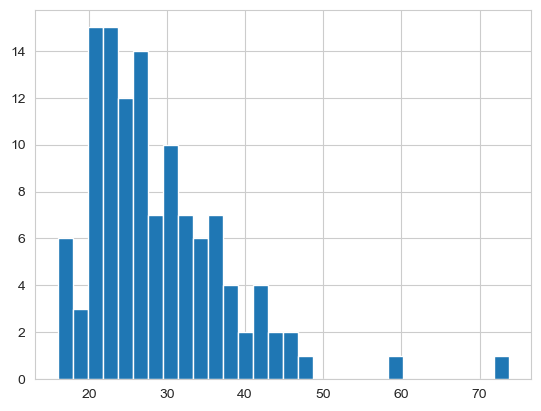

In [98]:
plt.hist(train_datasets[['med_Max_all_frames']], bins = 30)


## MSE simple benchmark

In [99]:
predicted_pressure_med = np.mean(train_datasets[['med_Max_all_frames']])
predicted_pressure_lat = np.mean(train_datasets[['lat_Max_all_frames']])
n = len(test_datasets[['lat_Max_all_frames']])

simple_prediction_med = [predicted_pressure_med for i in range(n)]
simple_prediction_lat = [predicted_pressure_lat for i in range(n)]


### Metrics for simple prediction

In [100]:
# The mean squared error
print("Mean squared error medial: %.2f" % mean_squared_error(simple_prediction_med, test_datasets[['med_Max_all_frames']]))
print("Mean squared error lateral: %.2f" % mean_squared_error(simple_prediction_lat, test_datasets[['lat_Max_all_frames']]))

Mean squared error medial: 82.12
Mean squared error lateral: 65.49


## Logistic Regression
### Choose some features

#### Train data set

In [101]:
train_x_LR = train_datasets[["Femur_volume", "Tibia_volume", "Femur_Car_volume",
                                "Tibia_L_Car_volume", "Tibia_L_Car_volume",
                                "Femur_bounds_x", "Tibia_bounds_x",
                                "Femur_Car_bounds_x",
                                "Tibia_M_Car_bounds_x", "Tibia_L_Car_bounds_x",
                                "Femur_bounds_y", "Tibia_bounds_y",
                                "Femur_Car_bounds_y",
                                "Tibia_M_Car_bounds_y", "Tibia_L_Car_bounds_y",
                                "Femur_bounds_z", "Tibia_bounds_z",
                                "Femur_Car_bounds_z",
                                "Tibia_M_Car_bounds_z", "Tibia_L_Car_bounds_z",
                                "Simulation_len",
                                "tib_med_curv", "tib_lat_curv",
                                "tib_med_ishealthy", "tib_lat_ishealthy",
                                "femur_gap_dist",
                                "Mean_dist_femur_tibia_lat_car", "Mean_dist_femur_tibia_med_car"]]

In [102]:
train_y_lat_LR = train_datasets[['lat_Max_all_frames']]
train_y_med_LR = train_datasets[['med_Max_all_frames']]

#### Test data set

In [103]:
test_x_LR = test_datasets[["Femur_volume", "Tibia_volume", "Femur_Car_volume",
                                "Tibia_L_Car_volume", "Tibia_L_Car_volume",
                                "Femur_bounds_x", "Tibia_bounds_x",
                                "Femur_Car_bounds_x",
                                "Tibia_M_Car_bounds_x", "Tibia_L_Car_bounds_x",
                                "Femur_bounds_y", "Tibia_bounds_y",
                                "Femur_Car_bounds_y",
                                "Tibia_M_Car_bounds_y", "Tibia_L_Car_bounds_y",
                                "Femur_bounds_z", "Tibia_bounds_z",
                                "Femur_Car_bounds_z",
                                "Tibia_M_Car_bounds_z", "Tibia_L_Car_bounds_z",
                                "Simulation_len",
                                "tib_med_curv", "tib_lat_curv",
                                "tib_med_ishealthy", "tib_lat_ishealthy",
                                "femur_gap_dist",
                                "Mean_dist_femur_tibia_lat_car", "Mean_dist_femur_tibia_med_car"]]

In [104]:
test_y_lat_LR = test_datasets[['lat_Max_all_frames']]
test_y_med_LR = test_datasets[['med_Max_all_frames']]

### Train LR model

In [105]:
# define the model
# Create linear regression object
regr_lat = linear_model.LinearRegression()
regr_med = linear_model.LinearRegression()

# Train the model using the training sets
regr_lat.fit(train_x_LR, train_y_lat_LR)
regr_med.fit(train_x_LR, train_y_med_LR)

LinearRegression()

### Verify results

In [106]:
# Make predictions using the testing set
test_y_med_LR_pred = regr_med.predict(test_x_LR)
test_y_lat_LR_pred = regr_lat.predict(test_x_LR)

In [107]:
# The coefficients
print("Coefficients medial: \n", regr_med.coef_)
print("Coefficients lateral: \n", regr_lat.coef_)

# The mean squared error
print("Mean squared error medial: %.2f" % mean_squared_error(test_y_med_LR_pred, test_y_med_LR))
print("Mean squared error lateral: %.2f" % mean_squared_error(test_y_lat_LR_pred, test_y_lat_LR))

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination medial: %.2f" % r2_score(test_y_med_LR_pred, test_y_med_LR))
print("Coefficient of determination lateral: %.2f" % r2_score(test_y_lat_LR_pred, test_y_lat_LR))

Coefficients medial: 
 [[-1.74160185e-04 -6.95094346e-05  3.07112637e-04  7.18242107e-04
   7.18241867e-04  4.22182247e-01  4.27062051e-01  1.29829201e-01
   4.08121657e-01 -1.62293671e-01  6.20517543e-01  4.14373083e-01
  -8.17037575e-01  3.46652703e-01 -1.25924473e-01  6.36634834e-01
  -2.66033446e-01 -3.26816188e-01  2.19823159e-01 -2.26894830e-01
  -2.57446383e-01  1.44063615e+02 -4.04180943e+01  5.40629567e+00
  -4.56911947e+00 -7.51444386e-01  1.58404205e-01 -1.52671274e+00]]
Coefficients lateral: 
 [[-8.44940938e-05 -8.33187974e-05 -1.46000726e-04  4.85544375e-04
   4.85544436e-04  2.13105313e-01  8.43314795e-02 -1.53011527e-01
   1.55750172e-01 -8.01138809e-01  4.86442132e-01  4.23422849e-01
   7.90852389e-01  3.50419486e-01  9.46678474e-02  7.87972313e-01
   6.90872068e-01 -1.33185221e+00 -2.22851407e-01 -1.89777390e-02
  -7.89451024e-01  2.45169353e+01  3.05680504e+01  1.38136911e+00
   4.77044340e+00  1.17559807e-01 -2.70432845e-01  1.41816044e+00]]
Mean squared error medial

## Regularized Regression

In [108]:
train_x = train_datasets.drop(['lat_Max_all_frames', 'med_Max_all_frames'], axis=1)
test_x = test_datasets.drop(['lat_Max_all_frames', 'med_Max_all_frames'], axis=1)

In [109]:
train_y_lat = train_datasets[['lat_Max_all_frames']]
train_y_med = train_datasets[['med_Max_all_frames']]

test_y_lat = test_datasets[['lat_Max_all_frames']]
test_y_med = test_datasets[['med_Max_all_frames']]

### Lasso

In [110]:
model_lasso_lat = linear_model.Lasso(alpha=10, max_iter=10000)
model_lasso_lat.fit(train_x, train_y_lat)

Lasso(alpha=10, max_iter=10000)

In [111]:
model_lasso_med = linear_model.Lasso(alpha=10, max_iter=10000)
model_lasso_med.fit(train_x, train_y_med)

Lasso(alpha=10, max_iter=10000)

In [112]:
test_y_lat_lasso_predict = model_lasso_lat.predict(test_x)
test_y_mrd_lasso_predict = model_lasso_med.predict(test_x)

In [113]:
# The mean squared error
print("Mean squared error medial: %.2f" % mean_squared_error(test_y_lat, test_y_lat_lasso_predict))
print("Mean squared error lateral: %.2f" % mean_squared_error(test_y_med, test_y_mrd_lasso_predict))

Mean squared error medial: 75.45
Mean squared error lateral: 82.33
